In [1]:
import os
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

# sample data loading

In [2]:
account_name = 'voyagefox_'
file_path = f'./json/{account_name}.json'

with open(file_path, 'r') as json_fp:
    palette_dict = json.load(json_fp)
    pass

account_name = 'voyagefox_'
file_path = f'../data/{account_name}.json'

with open(file_path, 'r') as json_fp:
    palette_dict = json.load(json_fp)
    pass

>>> original picture : voyagefox__055_3772Likes.png
>>> back_cols : ([65, 67, 70], [92, 84, 81], [150, 122, 108])
>>> fore_cols : ([36, 44, 49], [61, 62, 65])



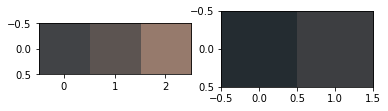

In [28]:
# check the loaded json
# palette_dict = {"voyagefox__055_3772Likes.png": [[[65, 67, 70], [92, 84, 81], [150, 122, 108]], [[36, 44, 49], [61, 62, 65]]], ...}

for item in palette_dict.items():
    file_name = item[0]
    back_cols = tuple(item[1][0])
    fore_cols = tuple(item[1][1])
    
    print(f'>>> original picture : {file_name}')
    print(f'>>> back_cols : {back_cols}')
    print(f'>>> fore_cols : {fore_cols}\n')
    break


# visualize one sample pair
back_cols_img = np.expand_dims(np.array(back_cols), 0)
fore_cols_img = np.expand_dims(np.array(fore_cols), 0)

ax1 = plt.subplot(121)
ax1.imshow(back_cols_img)

ax2 = plt.subplot(122)
ax2.imshow(fore_cols_img)
plt.show()

# How to use PIL Image, ImageDraw

In [4]:
# generate new background - Image.new(mode,size,color)
im=Image.new('RGB',(1000,1),(0,0,0))
print(type(im))
print(im)
im

<class 'PIL.Image.Image'>
<PIL.Image.Image image mode=RGB size=1000x1 at 0x2B4E7BD9320>


In [5]:
# colorize the background
draw=ImageDraw.Draw(im)
draw.rectangle((0*200, 0, 1*200, 1), fill=(255, 0, 0))
draw.rectangle((1*200, 0, 2*200, 1), fill=(0, 255, 0))
draw.rectangle((2*200, 0, 3*200, 1), fill=(0, 0, 255))
draw.rectangle((3*200, 0, 4*200, 1), fill=(255, 255, 0))
draw.rectangle((4*200, 0, 5*200, 1), fill=(0, 255, 255))
im

In [31]:
# colorize the background - using each palette in dataset
draw=ImageDraw.Draw(im)
batch = 200
for j, c in enumerate(back_cols + fore_cols):
    c = tuple(c)
    draw.rectangle((j*batch,0,(j+1)*batch,1),fill=c)
im

# Data reading function, generator for training 

During the generation process, the original color scheme is used as the label. The foreground colors will be concealed for training

In [11]:
def json_to_dataset(account_name, output_x_num=3, output_y_num=2):  # x == back_cols, y == fore_cols
    #file_path = f'../data/{account_name}.json'
    file_path = f'./json/{account_name}.json'

    with open(file_path, 'r') as json_fp:
        palette_dict = json.load(json_fp)
    print(f'>>> finished loading {len(palette_dict)} palettes')
    
    dataAB = []
    for back_cols, fore_cols in palette_dict.values():
        # select only given number of colors
        back_cols = back_cols[:output_x_num]
        fore_cols = fore_cols[:output_y_num]
        
        # generate a new image - Image.new(mode,size,color)
        im_size = (1000, 1)
        tmp_im = Image.new('RGB', im_size, (0,0,0))
        
        # colorize the image - using background & forground colors
        draw = ImageDraw.Draw(tmp_im)
        batch = int( im_size[0] / (output_x_num + output_y_num) )
        for idx, color in enumerate(back_cols + fore_cols):
            color = tuple(color)  # due to PIL datatype requirement
            draw.rectangle( xy=(idx*batch, 0, (idx+1)*batch, im_size[1]), fill=color )
        
        # append the colorized image
        dataAB.append(tmp_im)
        
    # random.shuffle(dataAB)  # shuffle dataset before train-validation-split
    trainAB = dataAB[ :int(len(dataAB) * 0.85) ]
    valAB = dataAB[ int(len(dataAB) * 0.85): ]
    return trainAB, valAB

In [12]:
def hide_y_cols(img_obj, x_num=3, y_num=2):
    img_fake = img_obj.copy()
    
    draw_fake = ImageDraw.Draw(img_fake)
    batch = int(img_fake.size[0] / (x_num+y_num))
    for index in range(x_num, x_num+y_num):
        draw_fake.rectangle( xy=(index*batch, 0, (index+1)*batch, img_fake.size[1]), fill=(0,0,0) )
    
    img_fake_arr = np.array(img_fake.resize((256,1))) / 255 * 2 - 1
    img_real_arr = np.array(img_obj.resize((256,1))) / 255 * 2 - 1
    return img_fake_arr, img_real_arr


def minibatch(dataAB, batchsize, input_x_num=3, input_y_num=2):
    length = len(dataAB) * 10
    epoch = 0
    
    tmp_start = 0
    tmp_size = None
    while True:
        size = tmp_size if tmp_size else batchsize
        
        # increase epoch
        if (tmp_start + size) > length:
            # random.shuffle(dataAB)
            tmp_start = 0
            epoch += 1
        
        dataA = []
        dataB = []
        for idx in range(tmp_start, tmp_start + size):
            idx = int(idx % len(dataAB))
            img_fake_arr, img_real_arr = hide_y_cols( dataAB[idx], input_x_num, input_y_num )
            dataA.append(img_fake_arr)
            dataB.append(img_real_arr)
        
        dataA = np.float32(dataA)
        dataB = np.float32(dataB)
        tmp_start += size
        
        tmp_size = yield epoch, dataA, dataB

In [38]:
def showX(X, epoch=0, rows=3, savefig=True):
    plt.figure(figsize=(10,5))
    X = np.concatenate(X,1)
    for i in range(rows):
        plt.subplot(2,3,i+1)
        plt.imshow(np.array(Image.fromarray(((X[i]+1)/2*255).clip(0,255).astype('uint8')).resize((512,100))))
    
    if savefig:
        if not os.path.exists('results/'):
            os.makedirs('results/')
        plt.savefig(f'results/epoch_{epoch}.png')
    
    plt.show()

# Visualization of training 

>>> finished loading 32 palettes


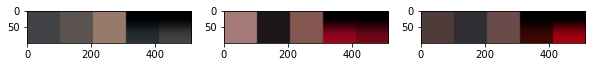

In [40]:
trainAB, valAB = json_to_dataset(account_name)

train_batch = minibatch(trainAB, batchsize=6)
_, trainA, trainB = next(train_batch)

showX([trainA, trainB], savefig=False)

del train_batch, trainA, trainB

# Models built 
Pix2pix's network structure is used for training. Some differences are in the input size. I use 256 1 instead of 256 256 in the image . The input becomes smaller, so I increased the number of channels. By default, the first layer uses 128. Channels.

In [15]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from keras.layers import Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import relu
from keras.initializers import RandomNormal
import keras.backend as K
from keras.optimizers import RMSprop, SGD, Adam
from keras.utils.vis_utils import model_to_dot
from keras.models import load_model

import random
import tensorflow as tf

from IPython.display import SVG
from IPython.display import clear_output

#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpu_options = tf.GPUOptions(allow_growth=True)
tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.2
2.2.4


In [16]:
# Basic discriminator
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02) # for batch normalization


def conv2d(f, *a, **k):
    return Conv2D(f, kernel_initializer = conv_init, *a, **k)
def batchnorm():
    return BatchNormalization(momentum=0.9, axis=-1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init)
def BASIC_D(nc_in=3, nc_out=3, ndf=128, max_layers=3):
    """DCGAN_D(nc, ndf, max_layers=3)
       nc: channels
       ndf: filters of the first layer
       max_layers: max hidden layers
    """    

    input_a, input_b = Input(shape=(None, None, nc_in)), Input(shape=(None, None, nc_out))
    _ = Concatenate(axis=-1)([input_a, input_b])
    _ = conv2d(ndf, kernel_size=(1,4), strides=(1,2), padding="same", name = 'First') (_)
    _ = LeakyReLU(alpha=0.2)(_)
    
    for layer in range(1, max_layers):        
        out_feat = ndf * min(2**layer, 8)
        _ = conv2d(out_feat, kernel_size=(1,4), strides=(1,2), padding="same", 
                   use_bias=False, name = f'pyramid.{layer}'
                        ) (_)
        _ = batchnorm()(_, training=1)        
        _ = LeakyReLU(alpha=0.2)(_)
    
    out_feat = ndf*min(2**max_layers, 8)
    _ = ZeroPadding2D((0,1))(_)
    _ = conv2d(out_feat, kernel_size=(1,4),  use_bias=False, name = 'pyramid_last') (_)
    _ = batchnorm()(_, training=1)
    _ = LeakyReLU(alpha=0.2)(_)
    
    # final layer
    _ = ZeroPadding2D((0,1))(_)
    _ = conv2d(1, kernel_size=(1,4), name = 'final'.format(out_feat, 1), 
               activation = "sigmoid") (_)    
    return Model(inputs=[input_a, input_b], outputs=_)

In [17]:
def UNET_G(isize, nc_in=3, nc_out=3, ngf=128, fixed_input_size=True):
    def block(x, s, nf_in, use_batchnorm=True, nf_out=None, nf_next=None, max_nf=8*ngf):
        # print("block",x,s,nf_in, use_batchnorm, nf_out, nf_next)
        assert s>=2 and s%2==0
        if nf_next is None:
            nf_next = min(nf_in*2, max_nf)
        if nf_out is None:
            nf_out = nf_in
        x = conv2d(nf_next, kernel_size=(1,4), strides=(1,2), use_bias=(not (use_batchnorm and s>2)),
                   padding="same", name = f'conv_{s}') (x)
        if s>2:
            if use_batchnorm:
                x = batchnorm()(x, training=1)
            x2 = LeakyReLU(alpha=0.2)(x)
            x2 = block(x2, s//2, nf_next)
            x = Concatenate(axis=-1)([x, x2])            
        x = Activation("relu")(x)
        x = Conv2DTranspose(nf_out, kernel_size=(1,4), strides=(1,2), use_bias=not use_batchnorm,
                            kernel_initializer = conv_init,          
                            name = f'convt.{s}')(x)        
        x = Cropping2D(cropping=((0,0),(1,1)))(x)
        if use_batchnorm:
            x = batchnorm()(x, training=1)
        if s <=8:
            x = Dropout(0.5)(x, training=1)
        return x
    
    
    s = isize if fixed_input_size else None
    
    inputs = Input(shape=(1, s, nc_in))        
    _ = block(inputs, s=isize, nf_in=nc_in, use_batchnorm=False, nf_out=nc_out, nf_next=ngf)
    _ = Activation('tanh')(_)
    
    return Model(inputs=inputs, outputs=[_])

In [18]:
first_filters = 128
netD = BASIC_D(ndf=first_filters)

imageSize = 256
netG = UNET_G(isize=imageSize)

netD.summary()
netG.summary()









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, None, None, 6 0           input_1[0][0]                    
                                                                 input_2[0][0]                    
_____________________________________________________________________________________

In [19]:
real_A = netG.input
fake_B = netG.output
netG_generate = K.function([real_A], [fake_B])

real_B = netD.inputs[1]
output_D_real = netD([real_A, real_B])
output_D_fake = netD([real_A, fake_B])

In [20]:
# Define loss function
loss_fn = lambda output, target : -K.mean(K.log(output+1e-12)*target+K.log(1-output+1e-12)*(1-target))

loss_D_real = loss_fn(output_D_real, K.ones_like(output_D_real))
loss_D_fake = loss_fn(output_D_fake, K.zeros_like(output_D_fake))
loss_G_fake = loss_fn(output_D_fake, K.ones_like(output_D_fake))

loss_L1 = K.mean(K.abs(fake_B-real_B))

In [21]:
# Select optimizer
lrD = 2e-4
loss_D = loss_D_real +loss_D_fake
training_updates = Adam(lr=lrD, beta_1=0.5).get_updates(netD.trainable_weights,[],loss_D)
netD_train = K.function([real_A, real_B], [loss_D/2], training_updates)

lrG = 2e-4
loss_G = loss_G_fake   + 100 * loss_L1
training_updates = Adam(lr=lrG, beta_1=0.5).get_updates(netG.trainable_weights,[], loss_G)
netG_train = K.function([real_A, real_B], [loss_G_fake, loss_L1], training_updates)

# Training 
During the training process, if the training is performed in the order of a generator and a discriminator, the result will be very poor, and the generation result is very bad, so the actual training one iteration took 3 times to generate a discriminant.

In [22]:
def netG_gen(A):
    return np.concatenate([netG_generate([A[i:i+1]])[0] for i in range(A.shape[0])], axis=0)

In [23]:
# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

batchSize = 1
niter = 5
display_iters = 2000

gen_iterations = 0
errL1 = epoch = errG = 0
errL1_sum = errG_sum = errD_sum = 0

train_batch = minibatch(trainAB, batchSize)
val_batch = minibatch(valAB, 6)

current_iter = 0
while epoch < niter: 
    epoch, trainA, trainB = next(train_batch)        
    errD,  = netD_train([trainA, trainB])
    errD_sum += errD
    
    errG, errL1 = netG_train([trainA, trainB])
    errG_sum += errG
    errL1_sum += errL1
    
    for i in range(3):        
        _, trainA1, trainB1 = next(train_batch)
        errG, errL1 = netG_train([trainA1, trainB1])
        errG_sum += errG
        errL1_sum += errL1
    
    gen_iterations += 1
    if gen_iterations % display_iters == 0:
        if gen_iterations % (5*display_iters) == 0:
            clear_output()
        print(f'[{epoch}/{niter}][{gen_iterations}] Loss_D: {errD_sum/display_iters} ' + 
              f'Loss_G: {errG_sum/(display_iters*4)} loss_L1: {errL1_sum/(display_iters*4)}')
        
        _, valA, valB = train_batch.send(6) 
        fakeB = netG_gen(valA)
        showX([valA, valB, fakeB], gen_iterations)
        
        errL1_sum = errG_sum = errD_sum = 0
        _, valA, valB = next(val_batch)
        fakeB = netG_gen(valA)
        showX([valA, valB, fakeB], gen_iterations)
        
    if epoch > current_iter:
        current_iter += 1
        
        if not os.path.exists('weights/100L1_128channel_4gen/generator/'):
            os.makedirs('weights/100L1_128channel_4gen/generator/')
        if not os.path.exists('weights/100L1_128channel_4gen/discriminator/'):
            os.makedirs('weights/100L1_128channel_4gen/discriminator/')
        
        netG.save(f'./weights/100L1_128channel_4gen/generator/epoch_{epoch}.hdf5')
        netD.save(f'./weights/100L1_128channel_4gen/discriminator/epoch_{epoch}.hdf5')

# Test

In [20]:
# Here I trained three models based on different parameters, used here as appropriate
# generator = load_model('weights/GAN/100L1_128channel_peisenet/generator/epoch_2.hdf5')
# generator1 = load_model('weights/GAN/100L1_128channel_4gen/generator/epoch_10.hdf5')
# generator2 = load_model('weights/GAN/1000L1_256channel/generator/epoch_10.hdf5')

generator = load_model('weights/100L1_128channel_4gen/generator/epoch_3.hdf5')
generator1 = load_model('weights/100L1_128channel_4gen/generator/epoch_4.hdf5')
generator2 = load_model('weights/100L1_128channel_4gen/generator/epoch_5.hdf5')

/home/ubuntu/anaconda3/envs/pj2_sam/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [21]:
for layer in generator.layers:
    layer.trainable = False

Processing palette 1 ... 


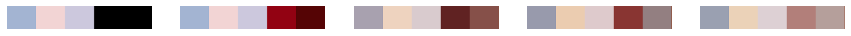

Processing palette 2 ... 


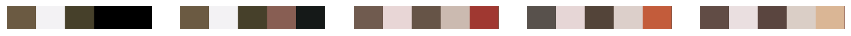

Processing palette 3 ... 


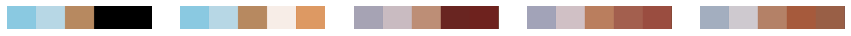

Processing palette 4 ... 


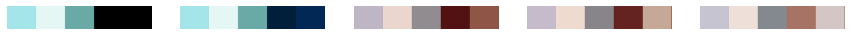

Processing palette 5 ... 


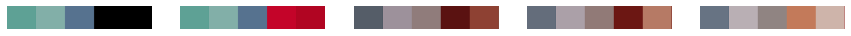

In [22]:
val_batch = minibatch(valAB, 1)
for idx in range(len(valAB[:10])):  # maximum 10 loop
    print(f'Processing palette {idx+1} ... ')
    
    # get fake & real array from minibatch
    _, valA, valB = next(val_batch)
    
    # transform normalized array(for model input) into pixel array
    im_fake = ((valA+1)/2*255).clip(0,255).astype('uint8')[0]
    im = ((valB+1)/2*255).clip(0,255).astype('uint8')[0]
    

    plt.figure(figsize=(15,15))
    
    # visualize original palette & concealed palette
    plt.subplot(1,5,1)
    plt.imshow(np.array(Image.fromarray(im_fake).resize((512,80))))
    plt.axis('off')

    plt.subplot(1,5,2)
    plt.imshow(np.array(Image.fromarray(im).resize((512,80))))
    plt.axis('off')
    
    # predict concealed colors
    result = generator.predict(valA)[0]
    result1 = generator1.predict(valA)[0]
    result2 = generator2.predict(valA)[0]
    
    batch = int(256 / 5)
    for i in range(5):
        result[:,i*batch:(i+1)*batch,:] = np.mean(result[:,i*batch:(i+1)*batch,:],1)[0]
        result1[:,i*batch:(i+1)*batch,:] = np.mean(result1[:,i*batch:(i+1)*batch,:],1)[0]
        result2[:,i*batch:(i+1)*batch,:] = np.mean(result2[:,i*batch:(i+1)*batch,:],1)[0]
    
    # visualize predicted colors
    plt.subplot(1,5,3)
    res = np.array(Image.fromarray(((result+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
    plt.imshow(res)
    plt.axis('off')

    plt.subplot(1,5,4)
    res1 = np.array(Image.fromarray(((result1+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
    plt.imshow(res1)
    plt.axis('off')

    plt.subplot(1,5,5)
    res2 = np.array(Image.fromarray(((result2+1)/2*255).clip(0,255).astype('uint8')).resize((512,80)))
    plt.imshow(res2)
    plt.axis('off')
    
    plt.show()